In [1]:
import t3f
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
tf.set_random_seed(0)
np.random.seed(0)
%matplotlib inline
import copy

In [48]:
import numpy as np
np.random.seed(0)
%matplotlib inline
import metric_util as mt
import data_util as du
from t3f import shapes
from nilearn import image

# Riemannian optimization

Riemannian optimization is a framework for solving optimization problems with a constraint that the solution belongs to a manifold. 

Let us consider the following problem. Given some TT tensor $A$ with large tt-ranks we would like to find a tensor $X$ (with small prescribed tt-ranks $r$) which is closest to $A$ (in the sense of Frobenius norm). Mathematically it can be written as follows:
\begin{equation*}
\begin{aligned}
& \underset{X}{\text{minimize}} 
& & \frac{1}{2}\|X - A\|_F^2 \\
& \text{subject to} 
& & \text{tt_rank}(X) = r
\end{aligned}
\end{equation*}

It is known that the set of TT tensors with elementwise fixed TT ranks forms a manifold. Thus we can solve this problem using the so called Riemannian gradient descent. Given some functional $F$ on a manifold $\mathcal{M}$  it is defined as
$$\hat{x}_{k+1} = x_{k} - \alpha P_{T_{x_k}\mathcal{M}} \nabla F(x_k),$$
$$x_{k+1} = \mathcal{R}(\hat{x}_{k+1})$$
with $P_{T_{x_k}\mathcal{M}}$ being the projection onto the tangent space of $\mathcal{M}$ at the point $x_k$ and $\mathcal{R}$ being a retraction - an operation which projects points to the manifold, and $\alpha$ is the learning rate.

We can implement this in `t3f` using the `t3f.riemannian` module. As a retraction it is convenient to use the rounding method (`t3f.round`).

In [3]:
sess = tf.InteractiveSession()

In [4]:
subject_scan_path = du.get_full_path_subject1()
print "Subject Path: " + str(subject_scan_path)
x_true_org = mt.read_image_abs_path(subject_scan_path)
x_true_img = np.array(x_true_org.get_data())

Subject Path: /work/pl/sch/analysis/data/COBRE001/swaAMAYER+cobre01_63001+M87100944+20110309at135133+RSTpre_V01_R01+CM.nii


In [5]:
def frobenius_norm_tf(x):
    return tf.reduce_sum(x ** 2) ** 0.5

In [6]:
def relative_error1(x_hat,x_true):
    percent_error = frobenius_norm_tf(x_hat - x_true) / frobenius_norm_tf(x_true)
    return percent_error

In [7]:
#shape = (3, 4, 4, 5, 7, 5)
shape = (53,63,46,144)
# Fix random seed so the results are comparable between runs.
tf.set_random_seed(0)
# Generate ground truth tensor A. To make sure that it has low TT-rank,
# let's generate a random tt-rank 5 tensor and apply t3f.full to it to convert to actual tensor.
#ground_truth = t3f.full(t3f.random_tensor(shape, tt_rank=5))
ground_truth = x_true_img


In [8]:
ground_truth_tf = t3f.to_tt_tensor(ground_truth, max_tt_rank=10)

[1, 10, 1, 1, 1] 0 (1, 53, 10)
[1, 10, 10, 1, 1] 1 (10, 63, 10)
[1, 10, 10, 10, 1] 2 (10, 46, 10)
ranks: [1, 10, 10, 10, 1]


In [9]:
A = t3f.get_variable('A', initializer=ground_truth_tf, trainable=False)

In [10]:
print A

A Tensor Train variable of shape (53, 63, 46, 144), TT-ranks: (1, 10, 10, 10, 1)


In [66]:
mask_indices = (np.random.rand(shape[0],shape[1],shape[2], shape[3]) < 60).astype('float32') 

In [67]:
x_train = copy.deepcopy(ground_truth)
x_train[mask_indices==0] = 0.0

In [13]:
x_train_tf = t3f.to_tt_tensor(x_train)

[1, 10, 1, 1, 1] 0 (1, 53, 10)
[1, 10, 10, 1, 1] 1 (10, 63, 10)
[1, 10, 10, 10, 1] 2 (10, 46, 10)
ranks: [1, 10, 10, 10, 1]


In [14]:

init_X = t3f.random_tensor(shape)
X = t3f.get_variable('X', initializer=x_train_tf)

gradF = X - A

In [15]:
riemannian_grad = t3f.riemannian.project(gradF, X)

In [16]:
# Let us compute the projection of the gradient onto the tangent space at X

In [17]:
def frobenius_norm_tf(x):
    return tf.reduce_sum(x ** 2) ** 0.5

In [18]:
def relative_error1(x_hat,x_true):
    percent_error = (frobenius_norm_tf(x_hat - x_true))**2 / (frobenius_norm_tf(x_true)**2)
    return percent_error

In [19]:
# let us also compute the value of the functional
# to see if it is decreasing
F = 0.5 * t3f.frobenius_norm_squared(X - A)

In [20]:
# Compute the update by subtracting the Riemannian gradient
# and retracting back to the manifold
alpha = 0.001

train_step = t3f.assign(X, t3f.round(X - alpha * riemannian_grad, max_tt_rank=10))
rel_error1 = relative_error1(t3f.full(X), t3f.full(A))


In [21]:
#sparse_observation = noisy_ground_truth * sparsity_mask

In [22]:
sess.run(tf.global_variables_initializer())

In [23]:
log = []
for i in range(100):
    F_v, rel_error1_v, _ = sess.run([F, rel_error1, train_step.op])
    print (F_v, rel_error1_v)
    log.append(F_v)

(4913.2524, 0.0)
(4200.46, 5.166912e-05)
(5638.0293, 4.9196442e-05)
(8548.441, 6.0805763e-05)
(13481.058, 1.588618e-05)
(17618.158, 6.5973624e-12)
(21174.545, 2.1363994e-06)
(23992.324, 7.7607865e-06)
(26946.998, 7.760797e-06)
(37183.445, 5.6238396e-06)
(40666.207, 1.5606487e-11)
(47019.523, 4.8048505e-06)
(55030.227, 1.1177593e-05)
(56697.465, 1.4305036e-05)
(63697.527, 2.1364374e-06)
(74668.49, 1.4305108e-05)
(79416.63, 2.1364501e-06)
(91279.69, 1.1709458e-05)
(96946.99, 3.6327337e-11)
(111541.2, 4.1129614e-11)
(121439.0, 4.5623935e-11)
(137761.33, 5.1375307e-11)
(157432.25, 5.7336583e-11)
(166336.02, 4.4392258e-05)
(179211.39, 6.3853804e-11)
(202752.88, 5.251988e-05)
(209809.72, 8.210127e-11)
(218459.89, 7.889649e-11)
(237475.11, 8.825874e-11)
(256660.98, 8.1254275e-06)
(282996.22, 1.01956436e-10)
(292674.7, 5.6240483e-06)
(307586.56, 3.0084357e-05)
(315671.12, 1.1573392e-10)
(328790.97, 3.8212766e-05)
(357450.16, 3.8212893e-05)
(370182.66, 1.4305752e-05)
(397385.62, 2.8057217e-05)


It is intructive to compare the obtained result with the quasioptimum delivered by the TT-round procedure. 

In [24]:
quasi_sol = t3f.round(A, max_tt_rank=2)

val = sess.run(0.5 * t3f.frobenius_norm_squared(quasi_sol - A))
print (val)

119444770000000.0


We see that the value is slightly bigger than the exact minimum, but TT-round is faster and cheaper to compute, so it is often used in practice.

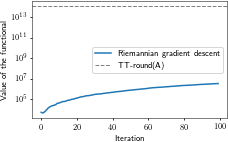

In [25]:
plt.semilogy(log, label='Riemannian gradient descent')
plt.axhline(y=val, lw=1, ls='--', color='gray', label='TT-round(A)')
plt.xlabel('Iteration')
plt.ylabel('Value of the functional')
plt.legend()

22117536.0

62271

3339747936

In [35]:
estimated_val = sess.run(t3f.full(X))

In [42]:
ground_truth_val = sess.run(t3f.full(ground_truth_tf))

In [37]:
def relative_error(x_hat,x_true):
    percent_error = np.linalg.norm(x_hat - x_true) / np.linalg.norm(x_true)
    return percent_error

In [44]:
rel_error = relative_error(estimated_val,ground_truth_val)

In [45]:
rel_error

3.429596e-05

In [39]:
print estimated_val

[[[[ 519.06647   509.44803   529.7056   ...  485.88043   523.64374
     527.0884  ]
   [ 568.76086   559.03674   577.7755   ...  536.5155    573.6848
     577.55347 ]
   [ 642.7025    634.2551    649.65967  ...  613.42084   648.52136
     652.64606 ]
   ...
   [ 108.08328   114.982796  115.31157  ...  117.05597   115.28321
     117.20515 ]
   [ 115.36697   118.81642   121.69205  ...  122.119675  119.289986
     124.56136 ]
   [ 108.82341   109.49072   113.87117  ...  113.431526  110.14745
     117.221466]]

  [[ 742.20074   732.2299    755.6116   ...  704.0952    750.85614
     754.9578  ]
   [ 805.47845   795.63763   816.9623   ...  769.08044   814.5513
     819.197   ]
   [ 898.8188    890.7033    907.86694  ...  866.32025   908.83276
     913.89215 ]
   ...
   [ 141.21483   150.62073   150.42     ...  153.16985   151.41737
     152.79976 ]
   [ 148.89816   153.79214   156.90761  ...  157.81004   154.60715
     160.37898 ]
   [ 140.06511   141.32457   146.45004  ...  146.14249   142.

In [43]:
print ground_truth_val

[[[[ 518.90967   509.27844   529.4918   ...  485.69888   523.48035
     526.9289  ]
   [ 568.6083    558.87244   577.5776   ...  536.3337    573.5266
     577.40063 ]
   [ 642.5557    634.0972    649.4805   ...  613.2459    648.3801
     652.5084  ]
   ...
   [ 108.248604  115.12261   115.48291  ...  117.215385  115.43436
     117.37866 ]
   [ 115.471146  118.89803   121.804565 ...  122.22374   119.37807
     124.66781 ]
   [ 108.88375   109.533295  113.94098  ...  113.49645   110.19265
     117.28005 ]]

  [[ 742.1101    732.1358    755.4502   ...  703.99255   750.7606
     754.8641  ]
   [ 805.3806    795.5369    816.8087   ...  768.965     814.44806
     819.09955 ]
   [ 898.7019    890.58466   907.7102   ...  866.1861    908.7224
     913.78564 ]
   ...
   [ 141.2066    150.58415   150.41339  ...  153.15346   151.39326
     152.79048 ]
   [ 148.8789    153.7491    156.89342  ...  157.79008   154.57005
     160.35153 ]
   [ 140.04373   141.28561   146.43616  ...  146.12663   142.210

In [46]:
from nilearn import plotting

In [49]:
x_true_org_img = image.index_img(x_true_org,1)

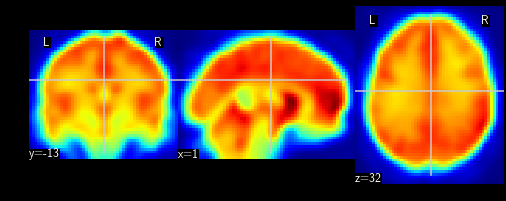

In [50]:
org_image = plotting.plot_epi(x_true_org_img, bg_img=None,black_bg=True, cmap='jet', cut_coords=None)

In [71]:

x_miss_img = mt.reconstruct_image_affine(x_true_org, x_train)

In [68]:
x_train = copy.deepcopy(ground_truth)
x_train[mask_indices==0] = 0.0

In [72]:
x_miss = image.index_img(x_miss_img,1)

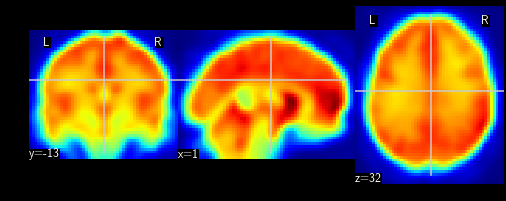

In [73]:
x_miss_image = plotting.plot_epi(x_miss, bg_img=None,black_bg=True, cmap='jet', cut_coords=None) 

In [74]:
plotting.show()

In [54]:
mask_indices

array([[[[1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
         ...,
         [1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.]],

        [[1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
         ...,
         [1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.]],

        [[1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
         ...,
         [1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.]],

        ...,

        [[1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
         ...,
         [1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
    